Preparation of catalogue `minijpas_cat_v1_HODsel_z0.1z0.4_imag21.csv` for use with correlation function code, including the generation (and preparation) of the associated random catalogue.

We follow the scheme of `alh_preparecats_ccdregs.py`, adapted to the new regions, radial selection, etc. done for miniJPAS.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy.coordinates as coord
import astropy.cosmology as asc
import pymangle
import dill

In [3]:
DEG2RAD = np.pi/180.
RAD2DEG = 180./np.pi

In [4]:
plt.style.use('seaborn-talk')

## Define parameters

### $N_{rand}$ and output files

In [5]:
NRANDREL = 100
out_data_name = "data_v1_HODsel_z0.1z0.4_imag21"
out_rand_name = "rand100_v1_HODsel_z0.1z0.4_imag21"
cat_suffix = ".xyz"
np_suffix = ".ngals"

### Input data

In [6]:
indatafile = "../data/minijpas_cat_v1_HODsel_z0.1z0.4_imag21.csv"
ra_label  = 'ALPHA'
dec_label = 'DELTA'
z_label = 'PHOTOZ'

### Cosmology

In [7]:
# From JPAS Cosmology
# http://www.j-pas.org/wiki/index.php/J-PAS_Parameter_Definition_Document
mycosmo = asc.FlatLambdaCDM(H0=67.74, Om0=0.3089, Ob0=0.0486)

# Will need to multiply manually in each case by 'h' to get 'Mpc/h' distances

### Selection functions

In [8]:
# Radial selection
radsel_file = "../get_radial_density/radsel_gausskde_v1_zall_imag21.pkl"
ZMIN = 0.1
ZMAX = 0.4

In [9]:
# Angular mask
angmask_file = "../masks/miniJPAS-PDR-v201912_simplelix.ply"

# Rectangle that contains the mask (to speed up things in `pymangle`)
RAMIN = 212
RAMAX = 217
DECMIN = 51
DECMAX = 55

### Definition of regions

In [10]:
# Rotation
alpha_c = 214.52
delta_c = 52.65
theta_deg = -45.0

# Reg. file
inregs_file = "../create_subregs_minijpas/subregs_minijpas_2x8.dat"

## Work with data catalogue

### Read input data

Read in data and select only relevant columns

In [11]:
dfdata = pd.read_csv(indatafile)[[ra_label, dec_label, z_label]]
Ndata = len(dfdata)
print(Ndata)

957


In [12]:
dfdata.head()

,ALPHA,DELTA,PHOTOZ
0,214.143996,52.241908,0.340
1,214.046558,52.303624,0.278
2,213.916553,52.374835,0.162
3,214.103429,52.273643,0.246
4,214.264547,52.184429,0.280


Check that the data used matches the selection in redshift

In [13]:
assert dfdata[z_label].min() >= ZMIN
assert dfdata[z_label].max() <= ZMAX

### Distances and Cartesian coordinates

Work always in Mpc/h units!!

In [14]:
dfdata['dist'] = mycosmo.comoving_distance(dfdata[z_label])*mycosmo.h

In [15]:
dfdata.head()

,ALPHA,DELTA,PHOTOZ,dist
0,214.143996,52.241908,0.340,935.755772
1,214.046558,52.303624,0.278,777.754518
2,213.916553,52.374835,0.162,466.958469
3,214.103429,52.273643,0.246,693.999512
4,214.264547,52.184429,0.280,782.939199


In [16]:
dfdata['x'], dfdata['y'], dfdata['z'] = \
    coord.spherical_to_cartesian(r=dfdata['dist'],
                                 lat=dfdata[dec_label]*DEG2RAD,
                                 lon=dfdata[ra_label]*DEG2RAD)

In [17]:
dfdata.head()

,ALPHA,DELTA,PHOTOZ,dist,x,y,z
0,214.143996,52.241908,0.340,935.755772,-474.223760,-321.604965,739.811420
1,214.046558,52.303624,0.278,777.754518,-394.056625,-266.260690,615.407760
2,213.916553,52.374835,0.162,466.958469,-236.569740,-159.067492,369.841186
3,214.103429,52.273643,0.246,693.999512,-351.623245,-238.097524,548.913459
4,214.264547,52.184429,0.280,782.939199,-396.725111,-270.267960,618.512898


### Assign galaxies in the catalogue to regions

#### Rotate coordinates

First, have to obtain the rotated coordinates for the galaxies!

In [18]:
def rotate_coordinates(alpha_c, delta_c, theta, data_df,
                      in_alpha_label='ALPHA', in_delta_label='DELTA',
                      out_alpha_label='ALPHA_rot', out_delta_label='DELTA_rot'):
    
    DEG2RAD = np.pi/180.
    RAD2DEG = 180./np.pi
    
    # Get Cartesian coordinates for the rotation axis
    rotaxis_cart = np.array(coord.spherical_to_cartesian(r=1, 
                                                         lat=delta_c*DEG2RAD,
                                                         lon=alpha_c*DEG2RAD
                                                        )
                           )
    
    # Get Cartesian coordinates for the data points
    points_cartesian = \
        np.array(coord.spherical_to_cartesian(r=1,
                                              lat=np.array(data_df[in_delta_label])*DEG2RAD,
                                              lon=np.array(data_df[in_alpha_label])*DEG2RAD)
                )
    
    # Do rotation of points using Rodrigues' formula
    theta_rad = theta*DEG2RAD
    term1 = points_cartesian*np.cos(theta_rad)
    term2 = np.cross(rotaxis_cart, points_cartesian.T).T*np.sin(theta_rad)
    term3 = np.outer(rotaxis_cart, np.dot(rotaxis_cart, points_cartesian))*(1. - np.cos(theta_rad))
    
    points_cart_new = term1 + term2 + term3
    
    # Convert back to 'new' spherical coordinates
    points_spher_new = \
        np.array(coord.cartesian_to_spherical(x=points_cart_new[0],
                                               y=points_cart_new[1],
                                               z=points_cart_new[2]))
    
    data_df[out_alpha_label] = points_spher_new[2]*RAD2DEG
    data_df[out_delta_label] = points_spher_new[1]*RAD2DEG

In [19]:
rotate_coordinates(alpha_c, delta_c, theta_deg, dfdata,
                  ra_label, dec_label)

In [20]:
dfdata.head()

,ALPHA,DELTA,PHOTOZ,dist,x,y,z,ALPHA_rot,DELTA_rot
0,214.143996,52.241908,0.340,935.755772,-474.223760,-321.604965,739.811420,213.778854,52.522346
1,214.046558,52.303624,0.278,777.754518,-394.056625,-266.260690,615.407760,213.780670,52.608151
2,213.916553,52.374835,0.162,466.958469,-236.569740,-159.067492,369.841186,213.770582,52.714654
3,214.103429,52.273643,0.246,693.999512,-351.623245,-238.097524,548.913459,213.786569,52.562367
4,214.264547,52.184429,0.280,782.939199,-396.725111,-270.267960,618.512898,213.798755,52.429540


#### Assign regions

Now, read in regions and assign regions to points

In [21]:
def assign_reg(ra_in,dec_in, dec_min_reg, dec_max_reg, ra_min_reg, ra_max_reg):

    Ncat = len(ra_in)
    if len(dec_in) != Ncat:
        raise ValueError

    Nreg = len(dec_min_reg)

    if (len(dec_max_reg) != Nreg) or (len(ra_min_reg) != Nreg) or (len(ra_max_reg) != Nreg):
        raise ValueError

    ind_reg = np.empty((Nreg, Ncat), bool)

    for i in range(Nreg):
        ind_reg[i] = (dec_in > dec_min_reg[i])&(dec_in <= dec_max_reg[i])&(ra_in > ra_min_reg[i])&(ra_in <= ra_max_reg[i])

    if ind_reg.sum() < Ncat:
        raise Exception("Looks like there are points in the catalogue outside of the regions defined!!")

    elif ind_reg.sum() < Ncat:
        raise Exception("Looks like there is some overlap between regions!!")

    ##Create the region ID array (each value shows what is the region that points is assigned to)
    reg_id = [np.arange(Nreg)[ind_reg[:,x]] for x in range(Ncat)]
    reg_id = np.array(list(reg_id))[:,0]
    if len(reg_id) != Ncat:
        raise Exception("Something went wrong when creating the region ID array, len(reg_id) = %d!" % len(reg_id))

    return reg_id

In [22]:
dec_min, dec_max, ra_min, ra_max = np.loadtxt(inregs_file, usecols=range(4), unpack=True)
Nreg = len(dec_min)

In [23]:
dfdata['reg_id'] = assign_reg(ra_in=dfdata['ALPHA_rot'],
                              dec_in=dfdata['DELTA_rot'],
                              dec_min_reg=dec_min, dec_max_reg=dec_max,
                              ra_min_reg=ra_min, ra_max_reg=ra_max)

In [24]:
dfdata.head()

,ALPHA,DELTA,PHOTOZ,dist,x,y,z,ALPHA_rot,DELTA_rot,reg_id
0,214.143996,52.241908,0.340,935.755772,-474.223760,-321.604965,739.811420,213.778854,52.522346,1
1,214.046558,52.303624,0.278,777.754518,-394.056625,-266.260690,615.407760,213.780670,52.608151,1
2,213.916553,52.374835,0.162,466.958469,-236.569740,-159.067492,369.841186,213.770582,52.714654,10
3,214.103429,52.273643,0.246,693.999512,-351.623245,-238.097524,548.913459,213.786569,52.562367,2
4,214.264547,52.184429,0.280,782.939199,-396.725111,-270.267960,618.512898,213.798755,52.429540,2


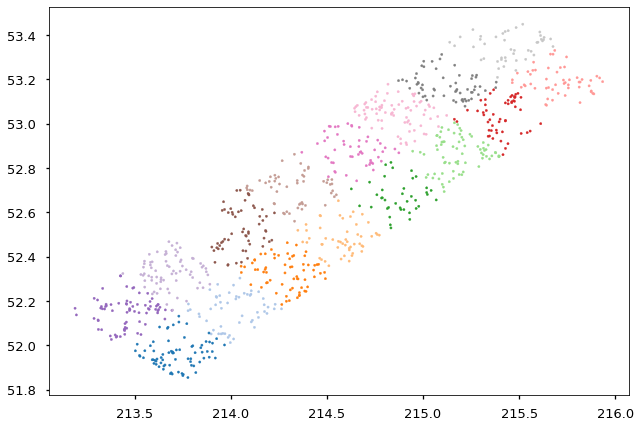

In [25]:
f, ax = plt.subplots()
ax.scatter(ra_label, dec_label, data=dfdata, s=5, c='reg_id',
            cmap='tab20', vmin=0, vmax=19)


Also, count no. of galaxies per region

In [26]:
n_gals_per_region = dfdata.groupby('reg_id').count()['x']

In [27]:
n_gals_per_region

reg_id
0     74
1     54
2     67
3     52
4     39
5     72
6     53
7     53
8     75
9     72
10    58
11    53
12    53
13    78
14    60
15    44
Name: x, dtype: int64

<AxesSubplot:xlabel='reg_id'>

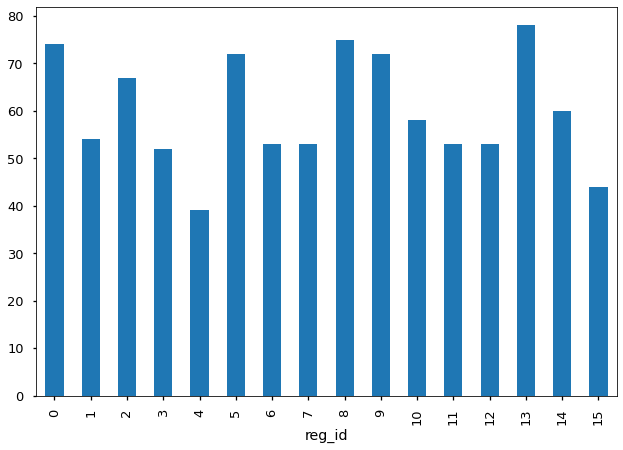

In [28]:
n_gals_per_region.plot(kind='bar')

### Save to files

In [29]:
out_cat_file = out_data_name + cat_suffix
dfdata.to_csv(out_cat_file, sep='\t', index=False, header=False,
              columns=['x', 'y', 'z', 'reg_id'])

In [30]:
out_cat_file

'data_v1_HODsel_z0.1z0.4_imag21.xyz'

In [31]:
!head {out_cat_file}

-474.2237596766912	-321.60496476402426	739.8114196344792	1
-394.05662515484715	-266.26069045736074	615.4077600800632	1
-236.5697399871982	-159.0674921743598	369.84118633952926	10
-351.62324489060194	-238.09752371299578	548.9134588848606	2
-396.72511086762563	-270.2679597207523	618.5128983860423	2
-372.7231374584352	-251.25090561827244	582.8745679464399	10
-401.6686738436345	-270.7735383311943	628.2153082892356	10
-511.63533721425046	-347.1639534922117	798.8805100102115	2
-526.3850902359434	-355.7700771928388	822.8871829331209	2
-383.0566218900054	-257.51217860629015	599.949268539341	10


In [32]:
out_np_file = out_data_name + np_suffix
n_gals_per_region.to_csv(out_np_file, index=False, header=False)

In [33]:
out_np_file

'data_v1_HODsel_z0.1z0.4_imag21.ngals'

In [34]:
!head {out_np_file}

74
54
67
52
39
72
53
53
75
72


## Work with random catalogue

Will define here **approximate** number of random points. For efficiency, we will get the actual number of random points when generating the distances (its a Poisson sampling), and use this to generate the angular positions.

In [35]:
Nrand_0 = Ndata*NRANDREL
print(Nrand_0)

95700


In [36]:
dfrand = pd.DataFrame()

### Generate distances

In [37]:
with open(radsel_file, 'rb') as f:
    radsel_kde = dill.load(f)

In [38]:
distmin = mycosmo.comoving_distance(ZMIN)*mycosmo.h
print(distmin)
distmax = mycosmo.comoving_distance(ZMAX)*mycosmo.h
print(distmax)

292.72374768535246 Mpc
1083.3477794183764 Mpc


In [39]:
radsel_kde

Get the fraction of the KDE that is actually inside the range of interest

In [40]:
frac_in_range = radsel_kde.integrate_box_1d(distmin.value, distmax.value)
print(frac_in_range)

0.22639684977528932


Will generate $N_{tot}$ = Nrand_0 / frac distances in total (in the whole KDE range),
and then select those that fall inside our range of interest.

In [41]:
Ntot = int(Nrand_0 / frac_in_range)
print(Ntot)

422709


In [42]:
distances_all = radsel_kde.resample(Ntot)[0]

In [43]:
inrange = (distmin.value <= distances_all) & (distances_all < distmax.value)
dfrand['dist'] = distances_all[inrange]

In [44]:
# Get actual number of random points generated
Nrand = len(dfrand) 
print(Nrand)

95499


array([[<AxesSubplot:title={'center':'dist'}>]], dtype=object)

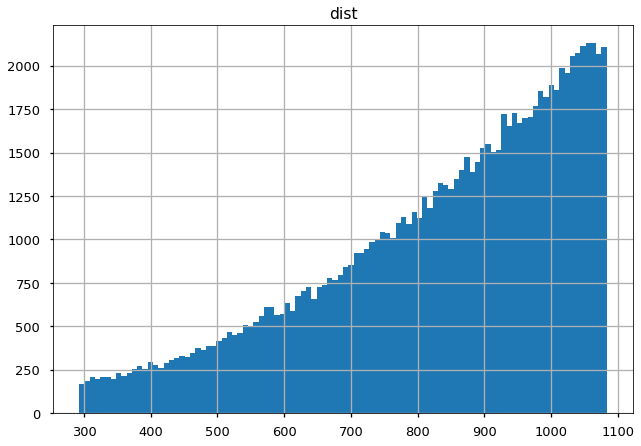

In [45]:
dfrand.hist('dist', bins=100)

### Generate angular positions

In [46]:
m = pymangle.Mangle(angmask_file)

In [47]:
dfrand[ra_label], dfrand[dec_label] = m.genrand_range(Nrand,
                                                      RAMIN, RAMAX,
                                                      DECMIN, DECMAX)

<AxesSubplot:xlabel='ALPHA', ylabel='DELTA'>

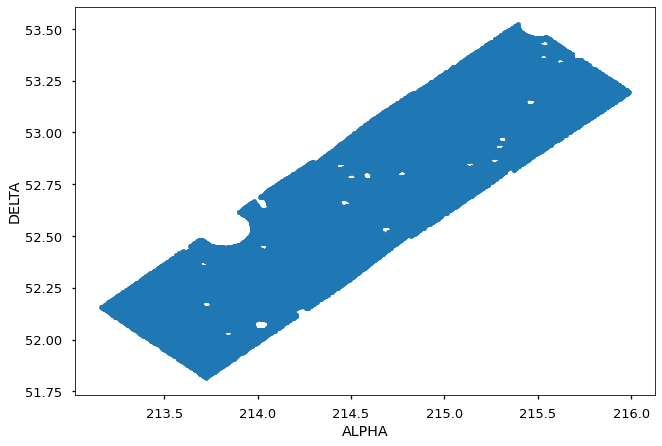

In [48]:
dfrand.plot(x=ra_label, y=dec_label, kind='scatter')

In [49]:
dfrand

,dist,ALPHA,DELTA
0,1001.621431,215.102843,53.110679
1,676.139842,213.537840,52.308196
2,997.599829,215.410668,53.323936
3,1014.749976,215.105907,52.805520
4,646.762657,215.261818,52.819053
...,...,...,...
95494,842.378119,214.314965,52.267803
95495,1068.547185,213.318263,52.133899
95496,913.313596,214.512036,52.327761
95497,854.732717,214.965941,52.984599


In [50]:
dfrand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95499 entries, 0 to 95498
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dist    95499 non-null  float64 
 1   ALPHA   95499 non-null  float128
 2   DELTA   95499 non-null  float128
dtypes: float128(2), float64(1)
memory usage: 3.6 MB


### Cartesian coordinates

Work always in Mpc/h units!!

In [51]:
dfrand['x'], dfrand['y'], dfrand['z'] = \
    coord.spherical_to_cartesian(r=dfrand['dist'].values,
                                 lat=dfrand[dec_label]*DEG2RAD,
                                 lon=dfrand[ra_label]*DEG2RAD)

In [52]:
dfrand.head()

,dist,ALPHA,DELTA,x,y,z
0,1001.621431,215.102843,53.110679,-491.890834,-345.743128,801.093371
1,676.139842,213.537840,52.308196,-344.578685,-228.399067,535.036897
2,997.599829,215.410668,53.323936,-485.634957,-345.258909,800.100240
3,1014.749976,215.105907,52.805520,-501.848631,-352.782423,808.337818
4,646.762657,215.261818,52.819053,-319.146636,-225.649264,515.295808


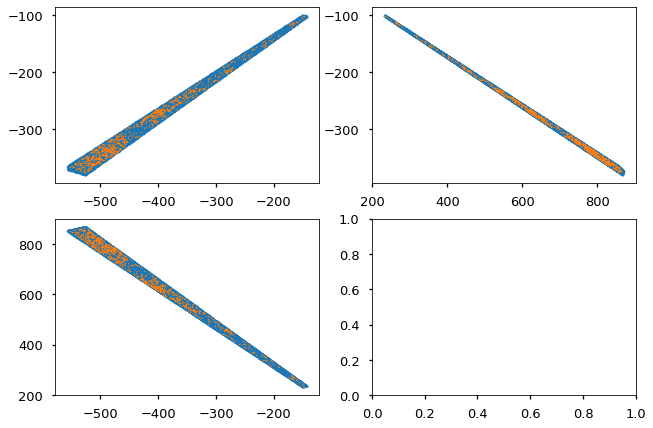

In [53]:
f, axes = plt.subplots(2,2, sharex=False, sharey=False)
axes[0,0].scatter('x', 'y', data=dfrand, s=1)
axes[0,0].scatter('x', 'y', data=dfdata, s=1)

axes[0,1].scatter('z', 'y', data=dfrand, s=1)
axes[0,1].scatter('z', 'y', data=dfdata, s=1)

axes[1,0].scatter('x', 'z', data=dfrand, s=1)
axes[1,0].scatter('x', 'z', data=dfdata, s=1)


### Assign points in the random catalogue to regions

#### Rotate coordinates

First, have to obtain the rotated coordinates for the points!

In [54]:
rotate_coordinates(alpha_c, delta_c, theta_deg, dfrand,
                  ra_label, dec_label)

In [55]:
dfrand.head()

,dist,ALPHA,DELTA,x,y,z,ALPHA_rot,DELTA_rot
0,1001.621431,215.102843,53.110679,-491.890834,-345.743128,801.093371,215.468031,52.725584
1,676.139842,213.537840,52.308196,-344.578685,-228.399067,535.036897,213.421903,52.830751
2,997.599829,215.410668,53.323936,-485.634957,-345.258909,800.100240,215.932520,52.744322
3,1014.749976,215.105907,52.805520,-501.848631,-352.782423,808.337818,215.113855,52.509049
4,646.762657,215.261818,52.819053,-319.146636,-225.649264,515.295808,215.238992,52.451992


#### Assign regions

Now, assign regions to points

In [56]:
dfrand['reg_id'] = assign_reg(ra_in=dfrand['ALPHA_rot'],
                              dec_in=dfrand['DELTA_rot'],
                              dec_min_reg=dec_min, dec_max_reg=dec_max,
                              ra_min_reg=ra_min, ra_max_reg=ra_max)

In [57]:
dfrand.head()

,dist,ALPHA,DELTA,x,y,z,ALPHA_rot,DELTA_rot,reg_id
0,1001.621431,215.102843,53.110679,-491.890834,-345.743128,801.093371,215.468031,52.725584,14
1,676.139842,213.537840,52.308196,-344.578685,-228.399067,535.036897,213.421903,52.830751,9
2,997.599829,215.410668,53.323936,-485.634957,-345.258909,800.100240,215.932520,52.744322,15
3,1014.749976,215.105907,52.805520,-501.848631,-352.782423,808.337818,215.113855,52.509049,5
4,646.762657,215.261818,52.819053,-319.146636,-225.649264,515.295808,215.238992,52.451992,5


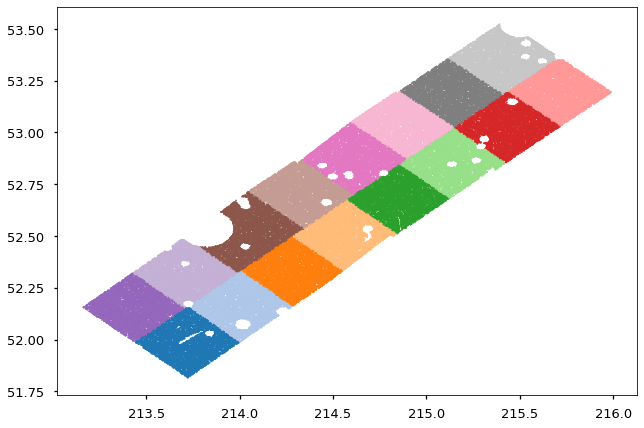

In [58]:
f, ax = plt.subplots()
ax.scatter(ra_label, dec_label, data=dfrand, s=2, c='reg_id',
            cmap='tab20', vmin=0, vmax=19)

Also, count no. of galaxies per region

In [59]:
n_gals_per_region_rand = dfrand.groupby('reg_id').count()['x']

In [60]:
n_gals_per_region_rand

reg_id
0     6024
1     5986
2     6087
3     5761
4     5965
5     5953
6     5980
7     5839
8     5932
9     6168
10    5922
11    6123
12    5923
13    5887
14    5902
15    6047
Name: x, dtype: int64

<AxesSubplot:xlabel='reg_id'>

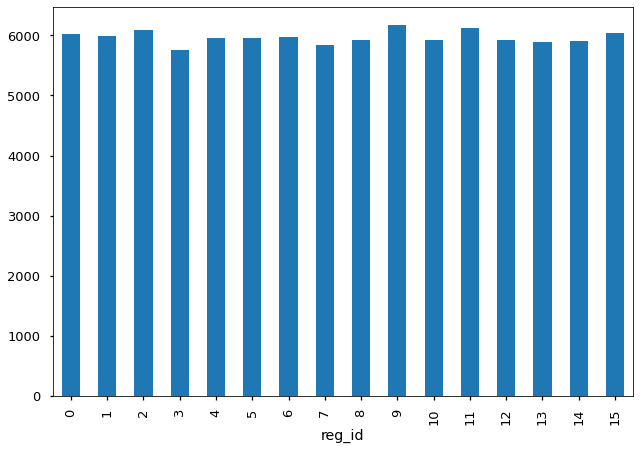

In [61]:
n_gals_per_region_rand.plot(kind='bar')

### Save to files

In [62]:
out_cat_rand_file = out_rand_name + cat_suffix
dfrand.to_csv(out_cat_rand_file, sep='\t', index=False, header=False,
              columns=['x', 'y', 'z', 'reg_id'])

In [63]:
out_cat_rand_file

'rand100_v1_HODsel_z0.1z0.4_imag21.xyz'

In [64]:
!head {out_cat_rand_file}

-491.8908337216599	-345.7431276491132	801.0933706860168	14
-344.57868536566156	-228.39906741093708	535.0368973902731	9
-485.63495699781095	-345.2589091362929	800.1002397909241	15
-501.84863109509	-352.78242268241667	808.3378176189694	5
-319.14663610161404	-225.64926368139	515.2958075009391	5
-483.358568340355	-319.98293029425633	746.6524894475166	8
-389.5629927650225	-268.40524305043283	615.6477121544871	3
-420.4596656565128	-296.15355007811314	689.7566096512164	14
-440.9056569654497	-310.60217673112686	722.9703666381007	14
-305.14339678792885	-218.25900355823623	500.09581672210686	7


In [65]:
out_np_rand_file = out_rand_name + np_suffix
n_gals_per_region_rand.to_csv(out_np_rand_file, index=False, header=False)

In [66]:
out_np_rand_file

'rand100_v1_HODsel_z0.1z0.4_imag21.ngals'

In [67]:
!head {out_np_rand_file}

6024
5986
6087
5761
5965
5953
5980
5839
5932
6168
